In [ ]:
# %pip install gdown
# %pip install pyspark
# %pip install matplotlib
# %pip install numpy
# %pip install pandas
# %pip install seaborn
# %pip install scikit-learn
# %pip install scipy
# %pip install statsmodels

In [14]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Fraud Detection Analysis") \
    .getOrCreate()

In [15]:
import os
import gdown

file_name = "Final Transaction.csv"

if not os.path.exists(file_name):
    url = "https://drive.google.com/file/d/1qJtOG4ReSYyaHn0xbitvXqESQS94OkqP/view?usp=drive_link"
    gdown.download(url, file_name, quiet=True, fuzzy=True)

df = spark.read.csv(file_name, header=True, inferSchema=True)
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- TRANSACTION_ID: integer (nullable = true)
 |-- TX_DATETIME: timestamp (nullable = true)
 |-- CUSTOMER_ID: integer (nullable = true)
 |-- TERMINAL_ID: integer (nullable = true)
 |-- TX_AMOUNT: double (nullable = true)
 |-- TX_TIME_SECONDS: integer (nullable = true)
 |-- TX_TIME_DAYS: integer (nullable = true)
 |-- TX_FRAUD: integer (nullable = true)
 |-- TX_FRAUD_SCENARIO: integer (nullable = true)



In [16]:
df.show(10)

+---+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|_c0|TRANSACTION_ID|        TX_DATETIME|CUSTOMER_ID|TERMINAL_ID|TX_AMOUNT|TX_TIME_SECONDS|TX_TIME_DAYS|TX_FRAUD|TX_FRAUD_SCENARIO|
+---+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|  0|             0|2023-01-01 00:00:31|        596|       3156|   533.07|             31|           0|       0|                0|
|  1|             1|2023-01-01 00:02:10|       4961|       3412|   808.56|            130|           0|       0|                0|
|  2|             2|2023-01-01 00:07:56|          2|       1365|  1442.94|            476|           0|       1|                1|
|  3|             3|2023-01-01 00:09:29|       4128|       8737|   620.65|            569|           0|       0|                0|
|  4|             4|2023-01-01 00:10:34|        927|       9906|   490.66|         

26/01/01 13:47:50 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , TRANSACTION_ID, TX_DATETIME, CUSTOMER_ID, TERMINAL_ID, TX_AMOUNT, TX_TIME_SECONDS, TX_TIME_DAYS, TX_FRAUD, TX_FRAUD_SCENARIO
 Schema: _c0, TRANSACTION_ID, TX_DATETIME, CUSTOMER_ID, TERMINAL_ID, TX_AMOUNT, TX_TIME_SECONDS, TX_TIME_DAYS, TX_FRAUD, TX_FRAUD_SCENARIO
Expected: _c0 but found: 
CSV file: file:///Users/bl-sw/code/Fraud-Detection-Kaggle/Final%20Transaction.csv


In [43]:
remove_cols = ['_c0', 'TRANSACTION_ID', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_FRAUD_SCENARIO']
df = df.drop(*remove_cols)
df.show(5)

+-------------------+---------+---------------+------------+--------+
|        TX_DATETIME|TX_AMOUNT|TX_TIME_SECONDS|TX_TIME_DAYS|TX_FRAUD|
+-------------------+---------+---------------+------------+--------+
|2023-01-01 00:00:31|   533.07|             31|           0|       0|
|2023-01-01 00:02:10|   808.56|            130|           0|       0|
|2023-01-01 00:07:56|  1442.94|            476|           0|       1|
|2023-01-01 00:09:29|   620.65|            569|           0|       0|
|2023-01-01 00:10:34|   490.66|            634|           0|       0|
+-------------------+---------+---------------+------------+--------+
only showing top 5 rows


# Exploratory Data Analysis

## 1. Dataset Overview


In [44]:
print(df.describe())
df.printSchema()

DataFrame[summary: string, TX_AMOUNT: string, TX_TIME_SECONDS: string, TX_TIME_DAYS: string, TX_FRAUD: string]
root
 |-- TX_DATETIME: timestamp (nullable = true)
 |-- TX_AMOUNT: double (nullable = true)
 |-- TX_TIME_SECONDS: integer (nullable = true)
 |-- TX_TIME_DAYS: integer (nullable = true)
 |-- TX_FRAUD: integer (nullable = true)



In [45]:
numerical_cols = ['TX_AMOUNT']
categorical_cols = ['']
target_cols = ['TX_FRAUD']
timestamp_cols = ['TX_DATETIME']
relative_time_cols = [
    "TX_TIME_SECONDS",
    "TX_TIME_DAYS"
]

## 2. Missing Values Check


In [46]:
from pyspark.sql.functions import col, isnan, count, when
from pyspark.sql.types import DoubleType, FloatType

exprs = []

for field in df.schema.fields:
    c = field.name
    dtype = field.dataType

    # Numeric → check NULL + NaN
    if isinstance(dtype, (DoubleType, FloatType)):
        exprs.append(
            count(
                when(col(c).isNull() | isnan(col(c)), c)
            ).alias(c)
        )
    # Non-numeric → chỉ check NULL
    else:
        exprs.append(
            count(
                when(col(c).isNull(), c)
            ).alias(c)
        )

missing_df = df.select(exprs)
missing_df.show(truncate=False)


+-----------+---------+---------------+------------+--------+
|TX_DATETIME|TX_AMOUNT|TX_TIME_SECONDS|TX_TIME_DAYS|TX_FRAUD|
+-----------+---------+---------------+------------+--------+
|0          |0        |0              |0           |0       |
+-----------+---------+---------------+------------+--------+



## 3. Descriptive Statistics


In [48]:
df.select(
    *numerical_cols,
    *target_cols,
    *timestamp_cols,
    *relative_time_cols
).describe().show()


+-------+------------------+-------------------+-----------------+-----------------+
|summary|         TX_AMOUNT|           TX_FRAUD|  TX_TIME_SECONDS|     TX_TIME_DAYS|
+-------+------------------+-------------------+-----------------+-----------------+
|  count|           1754155|            1754155|          1754155|          1754155|
|   mean|  539.681997280744| 0.1345200395632085|7903233.708571933|90.97260276315377|
| stddev|1179.7105939984608|0.34121029423187604|4565172.383899659|52.83709109961424|
|    min|               0.0|                  0|               31|                0|
|    max|          647837.5|                  1|         15811197|              182|
+-------+------------------+-------------------+-----------------+-----------------+



## 4. Target Variable Distribution (TX_FRAUD)


In [52]:
total = df.count()

fraud_dist = (
    df.groupBy("TX_FRAUD")
      .count()
      .withColumn("ratio", col("count") / total * 100)
      .orderBy("TX_FRAUD")
)

fraud_dist.show(truncate=False)


+--------+-------+-----------------+
|TX_FRAUD|count  |ratio            |
+--------+-------+-----------------+
|0       |1518186|86.54799604367915|
|1       |235969 |13.45200395632085|
+--------+-------+-----------------+



## 5. Important Features Analysis

### 5.1. TX_AMOUNT Analysis (Transaction Amount)


In [57]:
from pyspark.sql.functions import col, mean, stddev, min as spark_min, max as spark_max, count

print("=" * 60)
print("TX_AMOUNT ANALYSIS BY TX_FRAUD")
print("=" * 60)

amount_stats = (
    df.groupBy("TX_FRAUD")
      .agg(
          mean("TX_AMOUNT").alias("mean_amount"),
          stddev("TX_AMOUNT").alias("stddev_amount"),
          spark_min("TX_AMOUNT").alias("min_amount"),
          spark_max("TX_AMOUNT").alias("max_amount"),
          count("*").alias("count")
      )
      .orderBy("TX_FRAUD")
)


amount_stats.show(truncate=False)

# Display detailed statistics
print("\nDetailed statistics:")
for row in amount_stats.collect():
    fraud_label = "Fraud" if row['TX_FRAUD'] == 1 else "Non-Fraud"
    print(f"\n{fraud_label}:")
    print(f"  Mean:    {row['mean_amount']:.2f}")
    print(f"  StdDev:  {row['stddev_amount']:.2f}")
    print(f"  Min:     {row['min_amount']:.2f}")
    print(f"  Max:     {row['max_amount']:.2f}")
    print(f"  Count:   {row['count']:,}")



TX_AMOUNT ANALYSIS BY TX_FRAUD
+--------+------------------+------------------+----------+----------+-------+
|TX_FRAUD|mean_amount       |stddev_amount     |min_amount|max_amount|count  |
+--------+------------------+------------------+----------+----------+-------+
|0       |393.90920306207437|275.34467418810556|0.0       |1000.0    |1518186|
|1       |1477.5603430111585|2973.50249720581  |0.2       |647837.5  |235969 |
+--------+------------------+------------------+----------+----------+-------+


Detailed statistics:

Non-Fraud:
  Mean:    393.91
  StdDev:  275.34
  Min:     0.00
  Max:     1000.00
  Count:   1,518,186

Fraud:
  Mean:    1477.56
  StdDev:  2973.50
  Min:     0.20
  Max:     647837.50
  Count:   235,969


In [58]:
sample_df = (
    df.select("TX_AMOUNT", "TX_FRAUD")
      .sampleBy(
          "TX_FRAUD",
          fractions={0: 0.01, 1: 0.05},  # non-fraud ít, fraud nhiều
          seed=42
      )
      .toPandas()
)


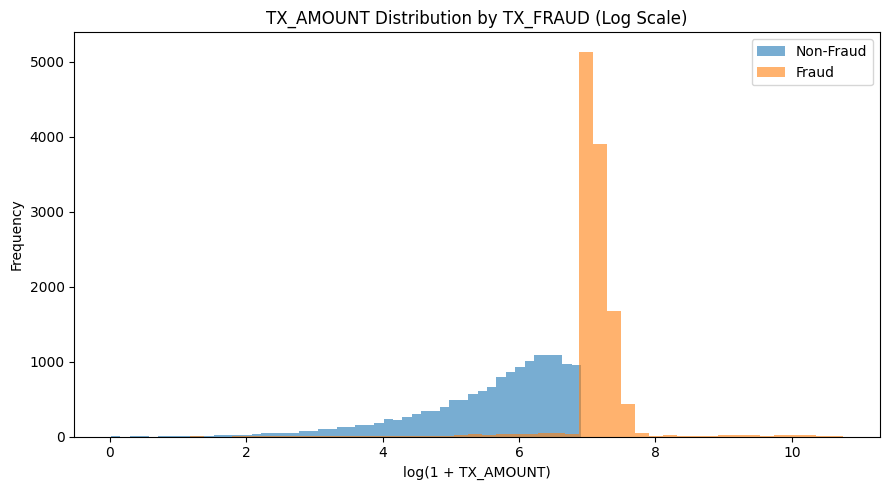

In [59]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9,5))

for label, name in [(0, "Non-Fraud"), (1, "Fraud")]:
    subset = sample_df[sample_df["TX_FRAUD"] == label]["TX_AMOUNT"]
    plt.hist(
        np.log1p(subset),
        bins=50,
        alpha=0.6,
        label=name
    )

plt.xlabel("log(1 + TX_AMOUNT)")
plt.ylabel("Frequency")
plt.title("TX_AMOUNT Distribution by TX_FRAUD (Log Scale)")
plt.legend()
plt.tight_layout()
plt.show()


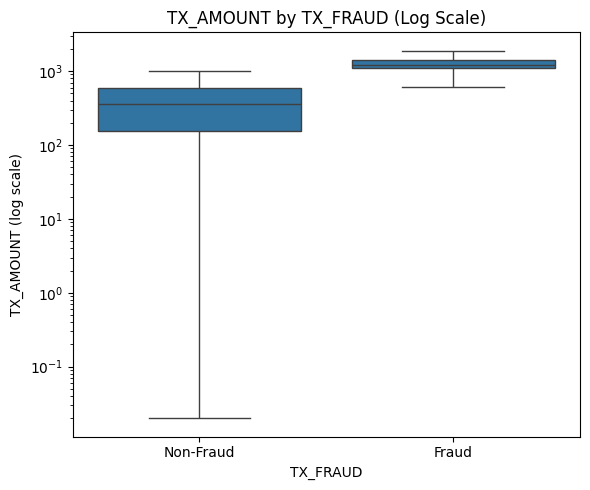

In [60]:
import seaborn as sns

plt.figure(figsize=(6,5))

sns.boxplot(
    x="TX_FRAUD",
    y="TX_AMOUNT",
    data=sample_df,
    showfliers=False
)

plt.yscale("log")
plt.xticks([0,1], ["Non-Fraud", "Fraud"])
plt.ylabel("TX_AMOUNT (log scale)")
plt.title("TX_AMOUNT by TX_FRAUD (Log Scale)")
plt.tight_layout()
plt.show()


### 5.3. Time-based Analysis


In [61]:
from pyspark.sql.functions import to_date, hour, dayofweek, count as spark_count, col, when, min as spark_min, max as spark_max

print("=" * 60)
print("TIME-BASED ANALYSIS")
print("=" * 60)

# Convert TX_DATETIME to date and extract time features
df_time = df.withColumn("TX_DATE", to_date("TX_DATETIME")) \
            .withColumn("TX_HOUR", hour("TX_DATETIME")) \
            .withColumn("TX_DAYOFWEEK", dayofweek("TX_DATETIME"))

# Time range of the dataset
date_range = df_time.select(
    spark_min("TX_DATE").alias("min_date"),
    spark_max("TX_DATE").alias("max_date")
).collect()[0]

print(f"\nTime range:")
print(f"  Start date: {date_range['min_date']}")
print(f"  End date: {date_range['max_date']}")

# Transaction distribution by day
print("\nTop 10 days with most transactions:")
daily_tx = df_time.groupBy("TX_DATE").agg(
    spark_count("*").alias("total_tx"),
    spark_count(when(col("TX_FRAUD") == 1, 1)).alias("fraud_tx")
).orderBy(col("total_tx").desc()).limit(10)
daily_tx.show(truncate=False)

# Transaction distribution by hour
print("\nTransaction distribution by hour of day:")
hourly_tx = df_time.groupBy("TX_HOUR").agg(
    spark_count("*").alias("total_tx"),
    spark_count(when(col("TX_FRAUD") == 1, 1)).alias("fraud_tx")
).orderBy("TX_HOUR")
hourly_tx.show(24, truncate=False)

# Transaction distribution by day of week
print("\nTransaction distribution by day of week:")
# 1 = Sunday, 2 = Monday, ..., 7 = Saturday
day_names = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 
             5: "Thursday", 6: "Friday", 7: "Saturday"}
dow_tx = df_time.groupBy("TX_DAYOFWEEK").agg(
    spark_count("*").alias("total_tx"),
    spark_count(when(col("TX_FRAUD") == 1, 1)).alias("fraud_tx")
).orderBy("TX_DAYOFWEEK")

print("Day        | Total Transactions | Fraud Transactions")
print("-" * 50)
for row in dow_tx.collect():
    day_name = day_names.get(row['TX_DAYOFWEEK'], f"Day {row['TX_DAYOFWEEK']}")
    print(f"{day_name:10s} | {row['total_tx']:>15,} | {row['fraud_tx']:>15,}")


TIME-BASED ANALYSIS

Time range:
  Start date: 2023-01-01
  End date: 2023-07-02

Top 10 days with most transactions:
+----------+--------+--------+
|TX_DATE   |total_tx|fraud_tx|
+----------+--------+--------+
|2023-04-01|9789    |1295    |
|2023-04-27|9787    |1344    |
|2023-04-06|9784    |1313    |
|2023-02-02|9771    |1414    |
|2023-02-15|9767    |1319    |
|2023-06-11|9762    |1367    |
|2023-01-30|9760    |1244    |
|2023-01-13|9753    |1349    |
|2023-02-09|9749    |1312    |
|2023-01-03|9747    |1309    |
+----------+--------+--------+


Transaction distribution by hour of day:
+-------+--------+--------+
|TX_HOUR|total_tx|fraud_tx|
+-------+--------+--------+
|0      |15137   |2031    |
|1      |21861   |2968    |
|2      |30140   |4051    |
|3      |40380   |5306    |
|4      |52403   |6887    |
|5      |65168   |8811    |
|6      |79880   |10925   |
|7      |94030   |12795   |
|8      |106617  |14411   |
|9      |116864  |15573   |
|10     |125804  |16793   |
|11     |1289

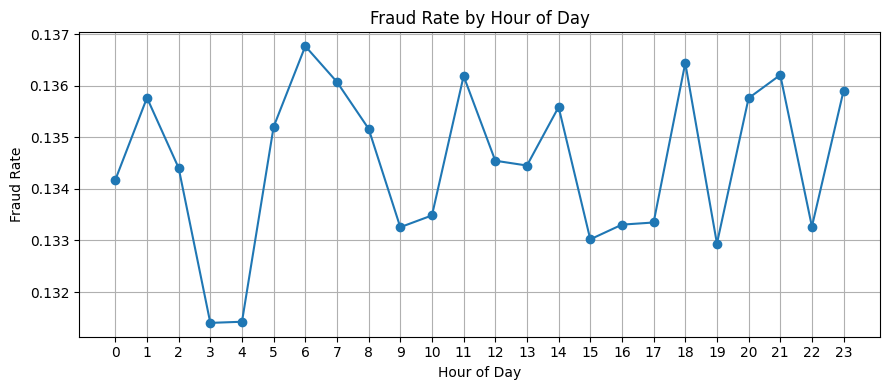

In [64]:
daily_pd = daily_tx.toPandas()
hourly_pd = hourly_tx.toPandas()
dow_pd = dow_tx.toPandas()


import matplotlib.pyplot as plt

hourly_pd["fraud_rate"] = hourly_pd["fraud_tx"] / hourly_pd["total_tx"]

plt.figure(figsize=(9,4))
plt.plot(
    hourly_pd["TX_HOUR"],
    hourly_pd["fraud_rate"],
    marker="o"
)

plt.xlabel("Hour of Day")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Hour of Day")
plt.xticks(range(0,24))
plt.grid(True)
plt.tight_layout()
plt.show()


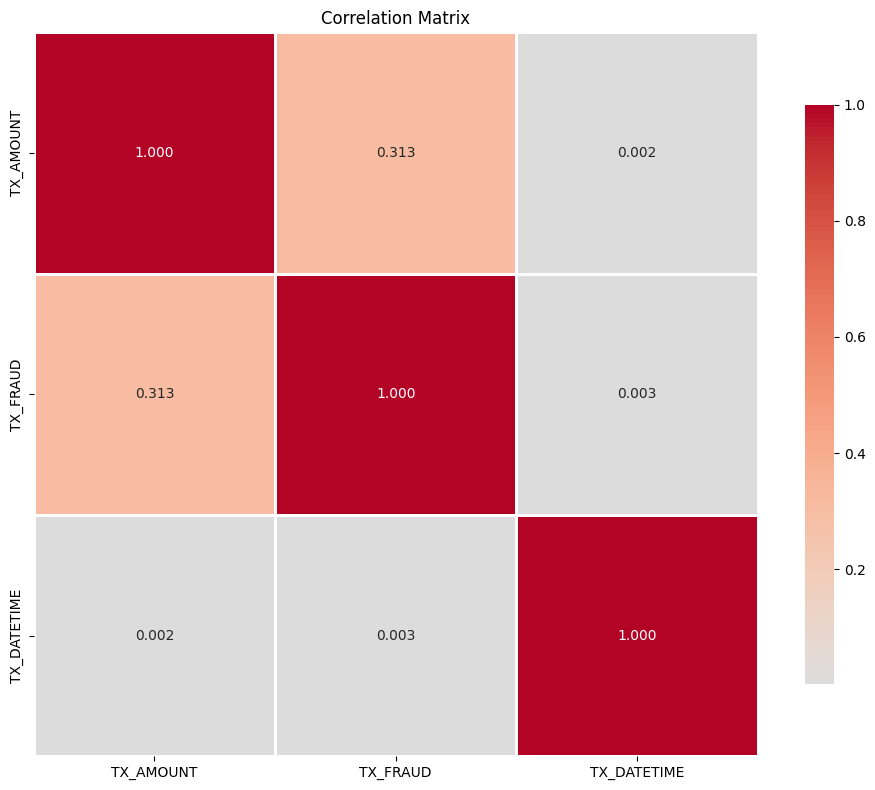

In [70]:
df_corr = df.select(
    *numerical_cols,
    *target_cols,
    *timestamp_cols,
).toPandas()


correlation_matrix = df_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()
